# MINERVA_2
> A reproduction of the classic instance-based model

In [1]:
import numpy as np
from numpy.linalg import norm


class ExemplarModel:
    """
    The basic exemplar model of memory as originated by Hintzman (1984, 1986, 1988) in MINERVA 2.

    In the model, every `experience` is represented as a vector - an ordered list of feature 
    
    values along many dimensions. A record of each experience - called a `trace` is stored as a 
    new, separate row in a m x n `memory` matrix where rows correspond to memory traces and 
    columns correspond to feature dimensions.

    To retrieve information from memory, a feature vector can be presented as a `probe`. The probe 
    activates all traces in memory in parallel. Each trace's `activation` is a cubed function of 
    its `similarity` to the probe. The sum of these traces weighted by their activation represents 
    an `echo` summarizing the memory system's response to the probe. The content and intensity of 
    this echo can serve downstream behavior such as recognition, word sense disambiguation, and 
    even free recall. For example, to compare memory representations associated with two probes, 
    the model can compute the resemblance (cosine similarity) between the echoes associated with 
    probes A and B.

    Attributes:
    - memory: array where rows correspond to accumulated memory traces and columns correspond to 
    feature dims
    """

    def __init__(self, experiences=None):
        """
        Inits exemplar model with initial set of experiences in memory (if any).
        """

        self.memory = None
        if experiences:
            self.experience(experiences)

    def experience(self, experiences):
        """
        Adds new experience(s) to model memory, represented as new row(s) in the model's memory 
        array.
        """
        self.memory = np.vstack(
            (self.memory, np.array(experiences))) if self.memory else np.array(experiences)

    def probe(self, probe):
        """
        Presents a cue to memory system, fetching echo reflecting its pattern of activation across 
        traces. The probe activates all traces in memory in parallel. Each trace's `activation` is 
        a cubed function of its `similarity` to the probe. The sum of these traces weighted by 
        their activation is an `echo` summarizing the memory system's response to the probe.
        """

        # computes and cubes similarity value to find activation for each trace in memory
        activation = np.power(
            np.sum(self.memory * probe, axis=1) / (norm(self.memory, axis=1) * norm(probe)), 3)

        # multiply each trace by its associated activation 
        # and take a column-wise sum to retrieve echo
        echo = np.sum((self.memory.T * activation).T, axis=0)
        return echo

    def compare_probes(self, first_probe, second_probe):
        """
        Compute the resemblance (cosine similarity) between the echoes associated with probes A 
        and B.
        """
        
        echoes = self.probe(first_probe), self.probe(second_probe)
        return np.sum(echoes[0] * echoes[1]) / (norm(echoes[0]) * norm(echoes[1]))

## Demonstration
We can apply this implementation of the classic model to reproduce some results from **Experiment 1:
Homonyms in an Artificial Language** of Jamieson et al (2018). The paper MINERVA 2 as a model of semantic
memory called ITS (Instance Theory of Semantics Memory), and considers whether it can track contextual
differences in word sense. For example, in some contexts "break" can have a similar meaning to the word
"report" (e.g. "break the news") while in other contexts "break" can have a similar meaning to the word
"smash" (e.g. "broke the toy"). ITS records a neutral record of word use in the corpus and develops a
representation of word meaning on-the-fly by parallel and probe-driven retrieval. This enables it to create
unique representations of the meaning of even same-spelled words that occur in different kinds of contexts. 

We start by building an artificial language corpus enforcing meaningful statistical regularities for our
model to infer.

In [2]:
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def artificial_language_corpus():
    """
    Generate a corpus of experiences to serve examination of ExemplarModel

    `words` are represented as a unique vector where each dimension takes a randomly sampled value from a
    normal distribution with mean zero and variance 1/n. Experiences are encoded as the sum of the word vectors
    occurring in a given context.

    A simple artificial language is constructed to generate a corpus of experiences (specified in Table 1 of
    paper), consisting of 12 words sorted between 7 lexical categories and 3 sentence frames grammatically
    specifying how triplets of words from different categories can be associated within a verbal context.

    To explore whether an exemplar model can predict human judgements even in the case of homonyms - words with
    the same spelling/pronunciation but different meanings - 20,000 grammatical sentences are sampled from the
    artificial language and encoded as experiences for an ExemplarModel instance.
    """

    # random vectors for each word
    word_list = ['man', 'woman', 'car', 'truck', 'plate', 'glass', 'story',
                'news', 'stop', 'smash', 'report', 'break']
    word_vectors = {word: np.random.normal(0, np.sqrt(1 / 20000), 20000) for word in word_list}

    # categories of lexical items
    lexical_items = {
        'NOUN_HUMAN': ['man', 'woman'],
        'NOUN_VEHICLE': ['car', 'truck'],
        'NOUN_DINNERWARE': ['plate', 'glass'],
        'NOUN_NEWS': ['story', 'news'],
        'VERB_VEHICLE': ['stop', 'break'],
        'VERB_DINNERWARE': ['smash', 'break'],
        'VERB_NEWS': ['report', 'break'],
    }

    # sample sentences and experiences
    sentences, experiences = [], []
    frames = np.random.choice([1, 2, 3], 20000)
    for i in range(20000):
        if frames[i] == 1:
            sentence = [np.random.choice(lexical_items['NOUN_HUMAN']),
                        np.random.choice(lexical_items['VERB_VEHICLE']),
                        np.random.choice(lexical_items['NOUN_VEHICLE'])]
        elif frames[i] == 2:
            sentence = [np.random.choice(lexical_items['NOUN_HUMAN']),
                        np.random.choice(lexical_items['VERB_DINNERWARE']),
                        np.random.choice(lexical_items['NOUN_DINNERWARE'])]
        else:
            sentence = [np.random.choice(lexical_items['NOUN_HUMAN']),
                        np.random.choice(lexical_items['VERB_NEWS']),
                        np.random.choice(lexical_items['NOUN_NEWS'])]

        sentences.append(sentence)
        experiences.append(np.sum([word_vectors[word] for word in sentence], axis=0))

    return {'word_list': word_list, 'word_vectors': word_vectors, 'lexical_items': lexical_items,
            'sentences': sentences, 'experiences': experiences}

Using a model encoding this corpus, we confirm that words that occur in similar contexts have similar
meanings by comparing their echoes against their co-occurrence frequencies in a contextual similarity
experiment.

In [3]:
def contextual_similarity_experiment(model):
    """
    Generates similarity matrix visualization testing if words in similar contexts have similar echoes.

    We compute and visualize a pairwise similarity matrix comparing echoes associated with each unique word to
    one another. Items in the same lexical categories (e.g. 'story' and 'news') occur in similar contexts and
    so should have similar echoes. Items in opposing lexical categories (e.g. 'story' and 'smash') should be
    found dissimilar. Items that occur equally often in every context ('break') should be somewhere in the
    middle.
    """

    # initiate model with corpus of word contexts as experiences
    corpus = artificial_language_corpus()
    model = model(corpus['experiences'])

    # compute pairwise similarities for each word in list
    similarities = np.full((len(corpus['word_list']), len(corpus['word_list'])), np.nan)
    for x in tqdm(range(len(corpus['word_list']))):
        for y in range(len(corpus['word_list'])):
            if x == y:
                continue
            word, other_word = corpus['word_list'][x], corpus['word_list'][y]
            similarities[x, y] = model.compare_probes(
                corpus['word_vectors'][word], corpus['word_vectors'][other_word])
    sns.heatmap(similarities, xticklabels=corpus['word_list'], yticklabels=corpus['word_list'],
                annot=True, linewidths=.5, cmap="YlGnBu")
    plt.savefig('results/contextual_similarity_experiment.svg')
    return corpus, similarities

With these functions, we apply the simulation to our implementation of the classic exemplar model. If the
simulation has worked out, the monogamous words from the vehicle topic are clustered together (i.e., stop,
car, truck), the monogamous words from the dinnerware topic are clustered together (i.e., plate, glass,
smash), the monogamous words from the news topic are clustered together (i.e., story, news, report), and the
promiscuous nouns (i.e., man, woman) are not so clustered with one another but highly clustered with other
terms while the promiscuous verb (break) is highly associated with every noun but not with other verbs.

These would correspond with the outcomes reported in the literature, and confirm that we can treat this
implementation of the MINERVA 2 model as a basis for further work.

100%|██████████| 12/12 [16:51<00:00, 84.32s/it]


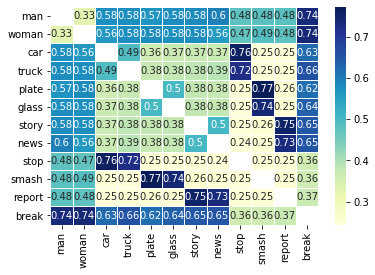

In [4]:
corpus, similarities = contextual_similarity_experiment(ExemplarModel)